In [12]:
import math
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt

# Implementar

### Log

In [13]:
def log_results(filename, poblacion_final):
    poblacion_final = poblacion_final.sort_values('apt')
    # Guardar población
    poblacion_final.to_csv(f'log/poblaciones/pop_{filename}.csv')

    # Estadísticos
    sol_min = poblacion_final.iloc[0]
    sol_max = poblacion_final.iloc[-1]
    apt_media = poblacion_final['apt'].mean()
    apt_std = poblacion_final['apt'].std()

    pop_stats = pd.Series({'min_crom': sol_min['cromosoma'], 'min_apt': sol_min['apt'],
                           'max_crom': sol_max['cromosoma'], 'max_apt': sol_max['apt'],
                           'media_apt': apt_media, 'std_apt': apt_std})
    pop_stats.to_csv(f'log/estadisticas/stats_{filename}.csv')


### Estructura cromosómica

In [14]:
class Gen:
    """
    Clase que representa la estructura y funcionamiento de un gen. No representa a un Gen.

    ...

    Attributes
    ----------
    dominio : tuple
        Dominio de valores reales del gen [x,y]
    precision : int
        Número de decimales que puede adquirir el valor real del Gen.
    len : int
        Longitud del Gen en su expresión binaria.
    norm : Decimal
        Constante de normalización del rango de valores binarios posibles del Gen al Dominio de sus valores reales.
    offset : Decimal
        Desplazamiento del Dominio expresado en valores enteros (sin punto decimal) a la región > 0.

    Methods
    -------
    translate(x,mode='decode')
        Traduce entre representación binaria de un Gen <-> expresión real
    """

    def __init__(self,dominio,precision):
        """
        Parameters
        ----------
        dominio : tuple
            Límites (liminf, limsup) de la variable en cuestión.
        precision : int
            Número de cifras decimales luego del punto para la variable en cuestión. Debe ser mayor al máximo número de decimales en el dominio
        """       
        self.dominio = dominio
        self.precision = precision
        self.len = self._length()

        # Offset lb -> all(0) ; ub -> all(1)
        self.norm = (Decimal(str(dominio[1])) - Decimal(str(dominio[0]))) *10**precision / int('1'*self.len,2)
        self.offset = Decimal(str(dominio[0])) #* 10**precision

    
    def _length(self):
        """Calcula el número de bits en un gen.

        Returns
        -------
        int
            Número de bits del gen <-> variable.
        """
        # Limites
        rango = self.dominio[1] - self.dominio[0]
        cell_count = math.ceil(np.log2(rango))

        # Decimales
        cell_count += math.ceil(np.log2(10**self.precision - 1))
        return cell_count
    
    def translate(self,x,mode='decode'):
        '''
        Traductor para codificar/decodificar (reales <-> binario) genes. 

        Parameters
        ----------
        x : float or str
            Gen a traducir (float si es un real, str si es binario).
        mode : str (code,decode)
            Uno de dos modos: 'code' para pasar de número real a binario, y 'decode' para pasar de binario a real.

        Returns
        -------
        str or float
            Gen traducido (str si x era un float, float si x era binario).
        '''
        
        if mode == 'code':
            ## Real -> Binario
            
            # Cortar decimales por redondeo
            x = float(x) # failsafe
            x = round(x,self.precision) - self.offset # precision y offset

            # Eliminar punto
            x_int,x_dec = str(x).split(".")
            x_dec = x_dec.ljust(self.precision,"0") # Rellena decimales de precision

            # Representación entera
            x_rep = int(x_int + x_dec)

            # Offset -> ran >= 0
            x_rep = Decimal(str(x_rep)) / self.norm
            x_rep = round(x_rep) # Nuevos decimales son de orden mayor a la precision
            return np.binary_repr(x_rep, width=self.len)
        
        elif mode == 'decode':
            ## Binario -> Real

            # Convierte a entero base 10
            x_rep = int(x,2)

            # Extraer Normalización
            x_rep = round(x_rep * self.norm)  # Nuevos decimales son de orden mayor a la precision + self.offset
            
            # Añadir el punto decimal
            x_rep = str(x_rep).zfill(self.precision) # Rellena decimales de precision
            int_part = x_rep[:-self.precision]
            dec_part = x_rep[-self.precision:]
            x_float = Decimal(int_part + '.' + dec_part)
            
            # Regresar offset
            x_float = x_float + self.offset 
            return float(x_float)

In [15]:
class Cromosoma:
    """
    Clase que representa la estructura y funcionamiento de un Cromosoma. No representa a un Cromosoma.

    ...

    Attributes
    ----------
    genes : tuple
        Tupla de objetos Gen en el Cromosoma, ordenados según el locus del gen.
    cromosoma : str
        Expresión binaria del cromosoma (genotipo). Es calculada sólo mediante el método "genotipo".
    crom_len : int
        Longitud del Cromosoma en su expresión binaria.

    Methods
    -------
    genotipo(x,mode='decode')
        Traduce entre representación binaria de un Cromosoma <-> expresión real de sus Genes.
    """

    def __init__(self,*genes):
        """
        Parameters
        ----------
        genes : Gen
            Gen(es) del cromosoma ordenado(s)
        """       
        
        self.genes = genes
        self.cromosoma = None
        self.crom_len = sum([gen.len for gen in genes])
        
    def genotipo(self,x,mode='decode'):
        '''
        Traductor para codificar/decodificar (reales <-> binario) cromosomas a través de sus genes.

        Parameters
        ----------
        x : list o str
            Expresión del cromosoma (lista si los genes se expresan en números reales, str si el cromosoma es binario)
        mode : str (code,decode)
            Uno de dos modos: 'code' para pasar de número real a binario, y 'decode' para pasar de binario a real.

        Returns
        -------
        str o list
            Cromosoma traducido (elementos tipo str si "genes" era una lista, lista si "genes" era binario).
        '''

        if mode == 'code':
            ## Real -> Binario
            genes_bin = [gen.translate(val, mode=mode) for val,gen in zip(x,self.genes)]
            self.cromosoma = ''.join(genes_bin)
            return self.cromosoma
        
        elif mode == 'decode':
            ## Binario -> Real
            genes_lens = [gen.len for gen in self.genes]
            ind_final = np.cumsum(genes_lens)
            genes_r = [gen.translate(x[ind-lens:ind]) for gen, lens, ind in zip(self.genes, genes_lens, ind_final)]
            return genes_r

### Algoritmo

In [16]:
class SimpleEvolutionary(Cromosoma):
    """
    Clase del Algoritmo Evolutivo Simple que hereda una estructura Cromosoma para funcionar.

    ...
    Methods
    -------
    genotipo(x,mode='decode')
        Traduce entre representación binaria de un Cromosoma <-> expresión real de sus Genes.
    """

    def optimize(self,f,N,num_gener,fast=False,verbose=True,export_name='Run'):
        '''
        Rutina de maximización de una función "f". Imprimime la información de cada generación.

        Parameters
        ----------
        f : function
            Función a maximizar
        N : int
            Número de individuos en la población inicial.
        num_gener : int
            Número de generaciones esperadas.
        fast : bool, optional
            Trunca el algoritmo cuando el mejor individuo de la generación anterior es igual al mejor individuo 
            de la generación actual (default=False)
        verbose : bool, optional
            Imprime información de los individuos y procesos de cada generación. (default=True)
        export_name : str, optional
            Nombre del archivo de registro de finalización del algoritmo. (default='se')

        Returns
        -------
        Series
            Mejor individuo (cromosoma binario, aptitud) al cumplirse los criterios de la rutina.
        '''
        self.f = f
        self.N = N
        self.mejor_individuo = None

        if N % 2 != 0: # Sólo poblaciones pares
            self.N = N + 1

        # Genera población aleatoria
        self.poblacion = self.random_generator(self.N,self.crom_len)

        for generacion in range(num_gener):
            # Selecciona padres
            par_selection = self.ruleta()
            # Cruza los padres 2 a 2
            mothers = par_selection.iloc[1::2]
            fathers = par_selection.iloc[::2]
            
            # Generación de hijos
            cruza = np.array(np.vectorize(self.cruza)
                            (mothers['cromosoma'],fathers['cromosoma'])
                            ).reshape(-1,1)
            n_muts, mutacion = np.vectorize(self.mutacion)(cruza)
            
            # Aptitud de hijos
            descendencia = pd.DataFrame([self.individuo(cromosoma[0]) for cromosoma in mutacion],
                                        columns = ['cromosoma','apt'])
            # Elitismo
            nueva_poblacion = self.sobrevivientes(descendencia)
            self.poblacion = nueva_poblacion
            
            # Imprimir descripción de la generación
            if verbose:
                self._gen_descripcion(generacion, mothers, n_muts)
            if fast and (self.mejor_individuo['apt'] == self.poblacion['apt'].iloc[0]):
                break
                
        log_results(filename=export_name, poblacion_final=self.poblacion)
        print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n','Mejor individuo:')
        print(self.mejor_individuo.to_dict())
        return self.mejor_individuo.to_dict()
    

    def _gen_descripcion(self,gener,cruzas,n_muts):
        '''
        Imprime la información de una generación
        '''
    
        apt_stats = f'''
        ##### Aptitud nominal #####
        Máximo: {self.poblacion['apt'].max()} | Media: {self.poblacion['apt'].mean()} | Mínimo: {self.poblacion['apt'].min()}
        '''
        #:.4f

        recombining_stats = f'''
        ##### Recombinación #####
        Cruzas: {len(cruzas)} | Mutaciones: {sum(n_muts)[0]}
        '''

        best_cr = self.mejor_individuo['cromosoma']
        best_individual = f'''
        ##### Mejor individuo #####
        Genotipo: {best_cr} | Fenotipo: {self.genotipo(best_cr)} | Aptitud: {self.mejor_individuo['apt']}
        '''

        print(f'Generación {gener+1} ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%\n', apt_stats, recombining_stats, best_individual)



    ##############################
    #### GENERACIÓN ALEATORIA ####
    def individuo(self,cromosoma):
        '''
        Genera un individuo (cromosoma,aptitud) a partir de su cromosoma.
        '''
        return cromosoma, self.f(*self.genotipo(cromosoma))
    
    def random_generator(self,N,size):
        '''
        Rutina de generación aleatoria de individuos

        Parameters
        ----------
        N : int
            Número de individuos en la población.
        size : int
            Longitud del cromosoma característico de los individuos en la población.

        Returns
        -------
        array
            Individuos generados como un array de cromosomas (col0) con su aptitud (col1) respectiva.
        '''
        # Creación de población de individuos
        poblacion = np.random.binomial(n=1, p=0.5, size=(N,size)).astype(str)
        poblacion = pd.DataFrame([self.individuo(''.join(cromosoma)) for cromosoma in poblacion],
                                 columns = ['cromosoma','apt']) 

        return poblacion
    

    ###############################
    #### SELECCIÓN: POR RULETA ####
    def ruleta(self):
        '''
        Selección de candidatos a reproducción de la población actual.

        Returns
        -------
        DataFrame
            Individuos seleccionados para reproducirse con la misma dimensión que la población.
        '''
        # Cálculo de proporción de aptitud y límites de probabilidad acumulada
        pi = self.poblacion['apt'] / self.poblacion['apt'].sum()
        pop_lims =  pd.DataFrame({'liminf': (pi).cumsum() - pi,
                                  'limsup': (pi).cumsum()})
        
        # Selección aleatoria de candidatos (lambda = |población|)
        R = np.random.uniform(0,1,pop_lims.shape[0])
        k_pop = pd.DataFrame(map(lambda x: self.poblacion[(pop_lims['liminf'] < x) & (x <= pop_lims['limsup'])].iloc[0], R))
        
        return k_pop
    
    ########################################
    #### OPERADOR CRUZA: CRUZA UN PUNTO ####
    def cruza(self,par1,par2,cr=0.8):
        '''
        Recombinación genética de dos individuos padres.

        Parameters
        ----------
        par1,par2 : str
            Cromosomas binarios de los padres a cruzar.
        cr : float
            Parametro de cruza que determina la eficacia de la cruza. 

        Returns
        -------
        tuple
            Cromosomas recombinados después de la cruza.
        '''
        fail = np.random.uniform(0,1)

        if fail < cr:
            crossover_point = np.random.randint(0, len(par1)) 
            ch1 = par1[:crossover_point] + par2[crossover_point:]
            ch2 = par2[:crossover_point] + par1[crossover_point:]
        else:
            ch1 = par1
            ch2 = par2
        return ch1, ch2
    
    ##############################################
    #### OPERADOR MUTACIÓN: INVERSIÓN DE BITS ####
    def mutacion(self,cromosoma,mr=None):
        '''
        Mutación aleatoria en un cromosoma.

        Parameters
        ----------
        cromosoma : str
            Cromosoma binario a mutar.
        mr : float, optional
            Probabilidad de que suceda una mutación en un locus del cromosoma (default= 1/len(cromosoma)).

        Returns
        -------
        tuple
            Número de mutaciones en el cromosoma y el cromosoma mutado.
        '''
        if not mr:
            mr = 1 / len(cromosoma)
        flip = np.random.binomial(1,mr,len(cromosoma))
        n_muts = sum(flip)
        mutated_cr = [str((int(d) + f) % 2) for d,f in zip(cromosoma,flip)]
        mutated_cr = ''.join(mutated_cr)
        return n_muts, mutated_cr
    
    #####################################
    #### SIGUIENTE POBLACIÓN (mu,mu) ####
    def sobrevivientes(self,descendientes):
        '''
        Selecciona la siguiente mutación (mu,mu) + elitismo. Intercambia el mejor individuo 
        de la generación anterior por el peor de la actual

        Parameters
        ----------
        descendientes : DataFrame
            Individuos resultantes de la reproducción de los padres de la generación anterior. 
            Es decir, es un DataFrame con cromosomas y su aptitud respectiva.

        Returns
        -------
        DataFrame
            Individuos sobrevivientes en la generación actual.
        '''
        # Mejor de la generación anterior
        elite_ind_idx = np.argmax(self.poblacion['apt'])
        elite_ind = self.poblacion.iloc[elite_ind_idx]  
        # Intercambiar el mejor de la generación anterior por el peor de la actual
        worst_ind_idx = np.argmin(descendientes['apt'])
        descendientes.iloc[worst_ind_idx] = elite_ind
        # Actualizar mejor individuo
        self.mejor_individuo = elite_ind
        return descendientes

# Resolver

$$ f(x_1,y_2) = 418.9829 \times 2 − x_1 \sin\left(\sqrt{\text{abs}(x_1)}\right) − x_2 \sin\left(\sqrt{\text{abs}(x_2)}\right) \text{ en } x_1, x_2 \in [-500,500]$$

In [17]:
def f(x,y):
    return 418.9829*2 - x*np.sin(np.sqrt(abs(x))) - y*np.sin(np.sqrt(abs(y)))

# f.__code__.co_argcount

In [18]:
# Definición de genes
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
CromA = Cromosoma(Gen1,Gen2)

In [19]:
# Algoritmo
se = SimpleEvolutionary(Gen1,Gen2)
se.optimize(f, N=100, num_gener=500)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1639.3326273454402 | Media: 979.0533788732928 | Mínimo: 412.47258232412076
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 106
         
        ##### Mejor individuo #####
        Genotipo: 0001001001101110111001101001011100011000011111001110001100000001111000100001010000101101 | Fenotipo: [-427.9952889552, 305.4217177586] | Aptitud: 1550.1981030325605
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1668.4191985799243 | Media: 1081.0013333419615 | Mínimo: 485.6209053011074
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 110
         
        ##### Mejor individuo #####
        Genotipo: 0001000101000110001000010010000111010101101100010111011101010110110110110110001110110101 | Fenotipo: [-432.5236599346, -408.3644323443] | Aptitud: 1639.3326273454402
        
Generación 3 ~%

{'cromosoma': '0001010000111100000000000000000010000100000000010100001110110110010010010011101001001101',
 'apt': 1675.93156369263}

# Extra

### Punto 1
Ejecución con parámetros mínimos 6 individuos y 2 generaciones donde se muestren la población (genotipo y fenotipo), los padres seleccionados, puntos de cruza, hijos, valores de mutación, etc.

In [20]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
se = SimpleEvolutionary(Gen1,Gen2)

In [21]:
se.optimize(f, N=6, num_gener=2)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1159.7555321207583 | Media: 872.0613311446544 | Mínimo: 482.5484063532434
         
        ##### Recombinación #####
        Cruzas: 3 | Mutaciones: 9
         
        ##### Mejor individuo #####
        Genotipo: 1100011011111111111100110010101010110001110110111101100110010100011011101100100010001010 | Fenotipo: [277.3429850803, 240.620072124] | Aptitud: 1015.9904705846096
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1159.7555321207583 | Media: 1009.1417233356774 | Mínimo: 837.7281627445678
         
        ##### Recombinación #####
        Cruzas: 3 | Mutaciones: 6
         
        ##### Mejor individuo #####
        Genotipo: 0000100110000100000110111110000111001001101010011101010000011100100010000100000101001101 | Fenotipo: [-462.8279279481, 114.2850229706] | Aptitud: 1159.7555321207583
        
~~~~~~~~~~~~~~~~~~~~~~~~~

{'cromosoma': '0000100110000100000110111110000111001001101010011101010000011100100010000100000101001101',
 'apt': 1159.7555321207583}

### Punto 2
Resultados promediados de 20 ejecuciones del algoritmo. Soluciones mínima, media, máxima y desviación estándar. Usar mismos parámetros para las 20 ejecuciones y reportarlos. Se debe generar un archivo por cada ejecución del algoritmo

In [22]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
se = SimpleEvolutionary(Gen1,Gen2)

In [28]:
# Algoritmo x 20 ejecuciones
stats_list = []
for n in range(20):
    print('\n | EJECUCIÓN ' + str(n))
    _ = se.optimize(f, N=6, num_gener=2, verbose=False, export_name='run'+str(n))
    stats_list.append(pd.read_csv(f'log/estadisticas/stats_{"run"+str(n)}.csv', index_col=0).T)

# Datos de las 20 ejecuciones
df_stats = pd.concat(stats_list, ignore_index=True)
cols_float = ['min_apt', 'max_apt', 'media_apt', 'std_apt']
df_stats[cols_float] = df_stats[cols_float].astype(float)


 | EJECUCIÓN 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001000111111101010101011010011011101111011000001000000010001011010100111011011011001111', 'apt': 1405.1308149098177}

 | EJECUCIÓN 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '1111100100111101101110100000101000110111111100010100010010110010111110111011001111001010', 'apt': 1149.5071454612007}

 | EJECUCIÓN 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0000101000000100011110110101011100010111100011001100101110000110000100011101000011010010', 'apt': 1367.803296224813}

 | EJECUCIÓN 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '1010011010000001110001100010010011000011011101101100110000100110111010001010111000010110', 'apt': 934.214222205907}

 | EJECUCIÓN 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '1001111101100110101111010111110011110100000000010100010101110000101111100001011001101100', 'apt': 1379.1984063995808}

 | EJECUCIÓN 5
~~

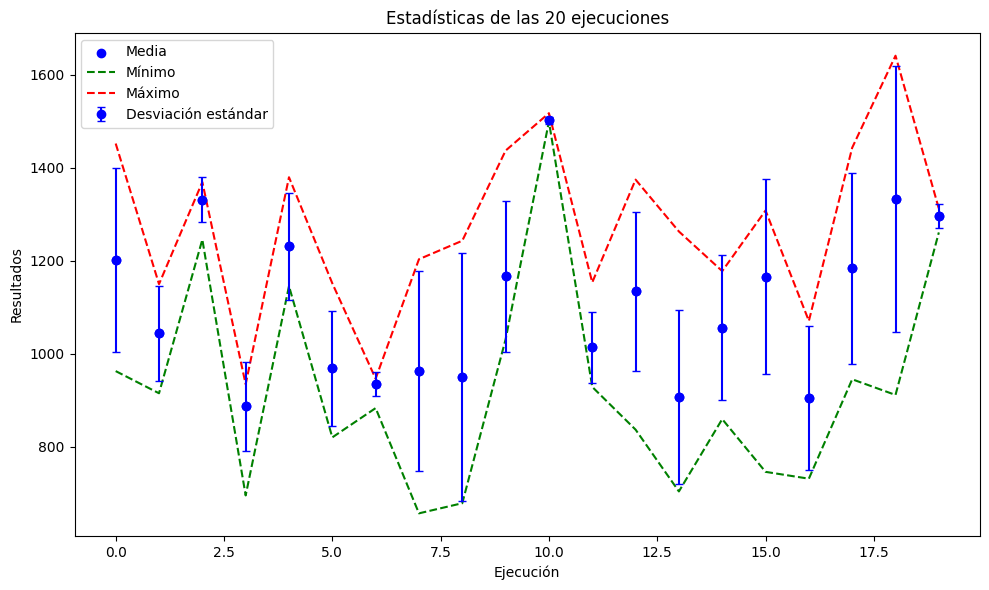

######## Resultados promediados ########
      Mínima: 922.6253915956793
      Media: 1108.5268688185433
      Máxima: 1498.8941728784866
      Desviación estándar: 141.6533274769865


In [29]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar medias
plt.scatter(df_stats.index, df_stats['media_apt'], color='blue', label='Media')

# Graficar mínimos y máximos
plt.plot(df_stats.index, df_stats['min_apt'], linestyle='--', color='green', label='Mínimo')
plt.plot(df_stats.index, df_stats['max_apt'], linestyle='--', color='red', label='Máximo')

# Graficar desviación estándar como barras de error
plt.errorbar(df_stats.index, df_stats['media_apt'], yerr=df_stats['std_apt'], fmt='o', color='blue', capsize=3, label='Desviación estándar')

# Presentación
plt.xlabel('Ejecución')
plt.ylabel('Resultados')
plt.title('Estadísticas de las 20 ejecuciones')
plt.legend()
plt.tight_layout()
plt.show()

print(f'''######## Resultados promediados ########
      Mínima: {df_stats['min_apt'].mean()}
      Media: {df_stats['media_apt'].mean()}
      Máxima: {df_stats['min_apt'].max()}
      Desviación estándar: {df_stats['std_apt'].mean()}''')


# Test

In [79]:
# arbitrary number of genes
Gen1 = Gen((-500,500),8)
Gen2 = Gen((-500,500),8)
CromA = Cromosoma(Gen1,Gen2)

In [82]:
se = SimpleEvolutionary(Gen1,Gen2)
se.optimize(f,100,1000,fast=True)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1495.8493296761048 | Media: 957.0031549592009 | Mínimo: 331.3530466162657
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 96
         
        ##### Mejor individuo #####
        Genotipo: 00011110000101001100100110011110101110001011001111111101111001001110001101 | Fenotipo: [-382.49530673, -412.1133917] | Aptitud: 1495.8493296761048
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1641.5663715247667 | Media: 993.334408023099 | Mínimo: 331.35304564801436
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 107
         
        ##### Mejor individuo #####
        Genotipo: 00011110000101001100100110011110101110001011001111111101111001001110001101 | Fenotipo: [-382.49530673, -412.1133917] | Aptitud: 1495.8493296761048
        
Generación 3 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        #

{'cromosoma': '00010100010000000011001100111110010000001010000111010111010000011011011010',
 'apt': 1675.9308885094504}

In [753]:
N = 30
crom_len = CromA.crom_len
pp = np.random.binomial(n=1, p=0.5, size=(N,crom_len))

pp = pp.astype(str)
pp_bin = np.array([''.join(xi) for xi in pp])

In [754]:
_realrep = np.array([CromA.representacion(cr,mode='decode') for cr in pp_bin])
__binrep = np.array([CromA.representacion(cr,mode='code') for cr in _realrep])

for i,j in zip(pp_bin,__binrep):
    if i!=j:
        print('i: ', CromA.representacion(i,mode='decode'), i)
        print('j: ', CromA.representacion(j,mode='decode'), j)
        print('#####################')

i:  [-119.61948, 265.793] 01100001011000001001111000111000100000010101111
j:  [380.38552, -233.707] 11100001011000001111001000001000100001010111100
#####################
i:  [-285.75998, 364.713] 00110110110110000110111100111011101010111011100
j:  [214.24503, -134.787] 10110110110110001100001100001011101011111101001
#####################
i:  [-210.54781, 270.335] 01001010000110011000100111111000101001101001010
j:  [289.4572, -229.165] 11001010000110011101110111101000101010101010111
#####################
i:  [442.28939, -206.819] 11110001001110011110000010001001011000011011110
j:  [-57.70561, 293.682] 01110001001110100011010010011001011001011101011
#####################
i:  [-294.34202, 44.812] 00110100101001100000000001110001011011110001100
j:  [205.66299, -454.688] 10110100101001100101010001000001011100110011001
#####################
i:  [398.79351, -491.776] 11100110000101110101010011000000010000110101111
j:  [-101.20149, 8.725] 01100110000101111010100011010000010001110111100
#######

In [755]:
_realrep
   

array([[-119.61948,  265.793  ],
       [-285.75998,  364.713  ],
       [-210.54781,  270.335  ],
       [ 442.28939, -206.819  ],
       [-294.34202,   44.812  ],
       [ 398.79351, -491.776  ],
       [  31.08428, -438.737  ],
       [ 455.58109,  340.573  ],
       [ 483.15024, -436.13   ],
       [-332.47894,  340.227  ],
       [-110.93287, -405.422  ],
       [-314.32529,  -63.168  ],
       [  87.29124, -309.644  ],
       [ 289.88194,  180.216  ],
       [-471.46873, -329.153  ],
       [  80.92293,  -32.307  ],
       [ 438.26174,  478.579  ],
       [ 432.6314 , -341.813  ],
       [ -10.54553,   86.731  ],
       [ 171.64204, -178.876  ],
       [-228.30143,  474.033  ],
       [ 141.67061, -468.806  ],
       [-345.86044, -316.615  ],
       [ 454.47862,  359.025  ],
       [-404.24997,  443.222  ],
       [ 250.44466,  202.735  ],
       [ 400.41406,  485.604  ],
       [-247.10562,  417.547  ],
       [ 340.01288, -267.555  ],
       [-166.88131, -409.507  ]])

### Test 2

In [30]:
se.poblacion = se.random_generator(1000,CromA.crom_len)

In [32]:
pars = se.ruleta()
mothers = pars.iloc[1::2]
fathers = pars.iloc[::2]

In [33]:
# Generación de hijos
cross = np.array(np.vectorize(se.cruza)
                (mothers['cromosoma'],fathers['cromosoma'])
                ).reshape(-1,1)
n_muts, mutacion = np.vectorize(se.mutacion)(cross)